<a href="https://colab.research.google.com/github/leandroleao2k/ImageML/blob/main/PCA%20Reducao%20Dimensionalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA 
##1) Normalização para dados ter media 0 e desvio padrão 1
##2) Calcular a matriz de covariância: 
Variancia quao espalhados estao os dados e
CoVariancia qual orientação   
##3) Calculo dos Autovetores e Autovalores da matriz de coVariancia
Isso vai caracterizar os dados onde os autovetores tentam capturar a variancia dos componentes
##4) Selecionar componentes principais
o autovetor com maior autovalor é o 1o 
##5) Executar a redução dimensionalidade 

https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca

(1797, 64)
(1797, 8, 8)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180]))
(8, 8)


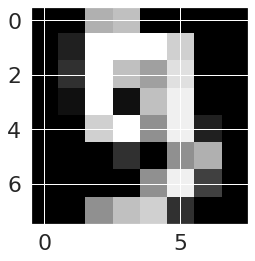

In [51]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Ellipse

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

%matplotlib inline
digits = load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(np.unique(digits.target, return_counts=True))

plt.gray()
plt.imshow(digits.images[9])
print(digits.images[9].shape)
#sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (20, 5)})

# Aplicando PCA

In [52]:
pca = PCA(n_components=8)
df_train = digits.data
pcaf = pca.fit(df_train)
print(pca.components_.shape)

(8, 64)


# Variancia
os prinmeiros components que mais explicam a variancia dos dados ex PC1, 2 e 3

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']


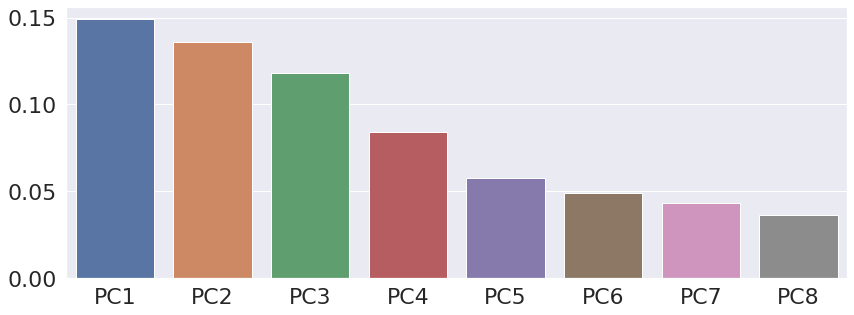

In [53]:
pc_lables = [] 
for i in range(pca.components_.shape[0]):
  pc_lables.append('PC{}'.format(i+1))
print(pc_lables)

plt.rcParams['figure.figsize'] = (14,5)
df = {
    'variance' : pca.explained_variance_ratio_,
    'principal_components' : pc_lables
}

sns.set(font_scale=2)
sns.barplot(x='principal_components', y='variance', data=df)

In [54]:
df_transformed = pca.fit_transform(df_train)
df_transformed = pd.DataFrame(df_transformed, columns=pc_lables)
df_transformed.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.259559,21.275018,-9.463168,13.014934,-7.122458,-7.446320,3.253497,2.549552
1,7.957716,-20.768742,4.439918,-14.893742,5.878368,-6.489041,2.141741,-4.701426
2,6.991937,-9.956001,2.958335,-12.287801,-18.125087,-4.501481,1.831673,-16.407642
3,-15.906157,3.332499,9.824362,-12.275865,6.967943,1.083490,-1.037819,10.970756
4,23.306837,4.269155,-5.675247,-13.851188,-0.354981,-2.843663,-0.732141,13.060590


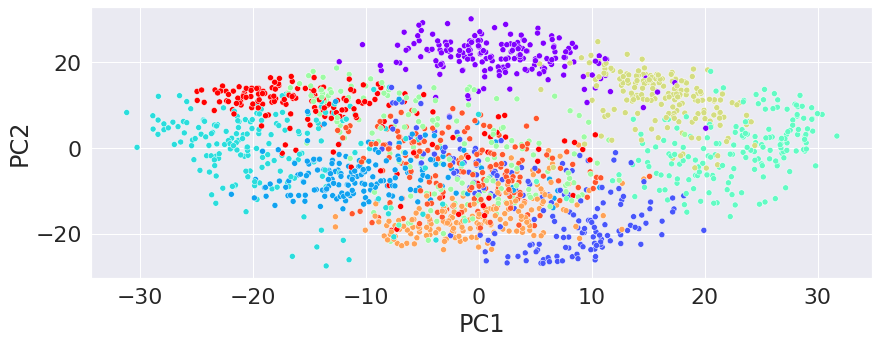

In [58]:
df = pd.DataFrame(df_transformed, columns=['PC1','PC2'])
df['label'] = digits.target
_ = sns.scatterplot(x='PC1', y='PC2', data=df, hue='label', palette='rainbow', legend=False)

# Cria Funcao para treinar GMM e plotar:
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [56]:
def treinar_plotar_gmm(data, k=3, covariance_type='full', tol=0.001, max_iter=100, n_init=1, init_params='kmeans', random_state=33):
  data_cp = data.copy()
  data_cp.drop (columns='label',inplace = True)

  model = GaussianMixture(n_components=k,covariance_type=covariance_type, tol=tol, max_iter=max_iter, n_init=n_init, 
                          init_params=init_params, random_state=random_state)
  model.fit(data_cp)
  data_cp['cluster_labels'] = model.predict(data_cp)
  _ = sns.scatterplot(x='x', y='y', data=data_cp, hue='cluster_labels', palette='rainbow', legend=False)
  
  means = model.means_
  means_x = means[:,0]
  means_y = means[:,1]
  _ = plt.scatter(means_x, means_y, color='black', s=100)
  w_factor = 0.2 / model.weights_.max()

  if covariance_type == 'tied':
    covars = np.repeat(model.covariances_, k, axis=0)
  else:
    covars = model.covariances_

  for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        draw_ellipse(pos, covar, covariance_type,alpha=w * w_factor)

  return model

def draw_ellipse(position, covariance, covariance_type, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covariance, 'tied',alpha=w * w_factor)

In [57]:
gmm = treinar_plotar_gmm (df, k=7, random_state=4000, init_params='random')

ValueError: ignored

## Testar uma base de dados torcida

In [ ]:
transformation = [[0.3,-0.3], [-1.2,0.2]]
X , y = make_blobs ( n_samples=1000, centers=7, n_features=2, random_state=170)
df_trans = pd.DataFrame(np.dot(X,transformation), columns=['x','y'])
df_trans['label'] = y
df_trans.head()

In [ ]:
ax = sns.scatterplot(x='x', y='y', data=df_trans, hue='label', palette='rainbow', legend=False)
_ = ax.axis('equal')

In [ ]:
gmm = treinar_plotar_gmm (df_trans, k=8, covariance_type = 'diag', max_iter = 1000, random_state=4000, init_params='kmeans')

In [ ]:
gmm = treinar_plotar_gmm (df_trans, k=8, covariance_type = 'full', max_iter = 1000, random_state=4000, init_params='kmeans')

# Método Cotovelo (Elbow)
### Estudo para achar o nro maximo de Clusters usando o Kmeans

In [ ]:
from sklearn.cluster import KMeans
def do_elbow_plot(dataframe, max_clusters):
  min_clusters=1
  clusters_range = range(min_clusters, max_clusters+1)
  inertias = []
  for k in clusters_range:
    model = KMeans(n_clusters=k, random_state=33)
    model.fit(dataframe)

    cur_inertia = model.inertia_
    inertias.append(cur_inertia)

  _ = plt.plot(clusters_range, inertias, '-o')
  _ = plt.title('Metodo Cotovelo para achar Max Clusters')
  _ = plt.xlabel('# clusters')
  _ = plt.ylabel('Inercia')
  _ = plt.xticks(clusters_range)
  plt.show() 

#### Note que o cotovelo sugere a mudança na inercia para valores >2 e <=8 

In [ ]:
%%time
do_elbow_plot(df, max_clusters=int(np.sqrt(len(df))))